## MNIST Multiclass Kernel Perceptrons
IDs: 23225718 and <>

In [1]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

#### Kernel Perceptron Class

In [2]:
class MultiClassKernelPerceptron():
    """
    A multiclass implementation of the kernel perceptron
    Designed for the MNIST dataset to classify digits 0-9
    """
        
    def __init__(self, kernel, num_digits=10):
        """
        Instantiates the perceptron instance

        Args:
            kernel: kernel function to use
            num_digits: optional param- number of digits to classify,
                assumes digits range from 0...num_digits
        """
        self.kernel = kernel
        self.num_classes = num_digits

    def train(self, X, Y, kernel_matrix=None, epochs=10):   
        """
        Trains the perceptron

        Args:
            X: training data (n x d)
            Y: training labels (n x 1)
            kernel_matrix: optional pre-calculated kernel matrix
            epochs: number of epochs to run
        """
        self.X_training = X
        Y = Y.astype(int)

        # Calculate gram matrix if necessary
        if kernel_matrix is not None:
            self.gram_matrix = kernel_matrix
        else: 
            self.gram_matrix = self.get_kernel_matrix(self.kernel, X)

        self.alpha = self.update_alpha(self.gram_matrix, Y, self.num_classes, epochs)
    
    # Pulling this into a separate function for numba,
    #   but consider this as if it were appended to the train method
    @staticmethod
    @jit(nopython=True)
    def update_alpha(gram_matrix, Y, num_classes, epochs):
        
        num_data = gram_matrix.shape[0]
        alpha = np.zeros((num_data, num_classes), dtype=np.float32)

        # To boost efficiency, let's keep track of non-zero alpha weights
        # Note that a data index is nontrivial if its alpha is nonzero for ANY perceptron
        nontrivial_indices = np.empty(num_data, dtype=np.int32)
        cur_nontrivial_idx = 0

        # Instantiate once and reuse in update step
        label_vector = -1 * np.ones(num_classes, dtype=np.float32)
        zeros = np.zeros(num_classes, dtype=np.float32)
        decisions = np.sign(zeros)
        
        for epoch in range(epochs):
            for i in range(num_data):
                # Get decisions for all the classifiers
                if (cur_nontrivial_idx > 0):
                    # Pull out the relevant values of alpha and the gram matrix
                    data_to_consider = nontrivial_indices[:cur_nontrivial_idx]
                    decisions = np.sign(np.dot(
                        alpha[data_to_consider].T,
                        gram_matrix[:, i][data_to_consider]
                    ))

                # The label vector should be -1 for every index
                # except the one corresponding to the current Yi label
                label_vector[Y[i]] = 1

                # For a given classifier, if the decision * label <= 0,
                # the update is the label, otherwise it is zero
                update = np.where(decisions*label_vector <=0, label_vector, zeros)

                # Add the update to alpha, reset label vector
                if (np.any(update != 0) and not np.any(alpha[i,:] != 0)):
                    nontrivial_indices[cur_nontrivial_idx] = i
                    cur_nontrivial_idx += 1

                alpha[i,:] += update
                label_vector[Y[i]] = -1
        
        return alpha
                
    def predict(self, X, kernel_matrix=None):
        """
        Predicts the labels of a new set of data

        Args:
            X: data to classify
            kernel_matrix: an optional parameter for a precalculated kernel
                between X and the training data
        """
        # If we need to compute a kernel matrix, we only need to find distances
        #   where the alphas are not 0.
        relevant_indices = np.where(np.sum(self.alpha != 0, axis=1) > 0)[0]
        if kernel_matrix is None:
            kernel_matrix = self.get_kernel_matrix(self.kernel, X, self.X_training[relevant_indices])
        else: 
            kernel_matrix = kernel_matrix[:, :][:, relevant_indices]
        
        alpha = self.alpha[relevant_indices]

        # See how confident each classifier is that a given point is in that class
        #   i.e. the distance between the point and the decision boundary
        # We want to get a N x K matrix where N = number of classifiers, K = num data in X
        # Each value is given by the dot product of the alphas for the classifier
        #   and the distances from the data point to the training examples
        data_confidence_by_classifier = kernel_matrix @ alpha
        
        # Pick the label of the classifier with the max confidence
        # Each classifier operates on a 1-v-All basis
        predictions = np.argmax(data_confidence_by_classifier, axis=1)
        return predictions
    
    @staticmethod
    @jit(nopython=True)
    def get_kernel_matrix(kernel_func, X1, X2=None):
        """
        Calculates the full kernel matrix between X1 and X2
        using an input kernel function

        Args:
            kernel_func: kernel function
            X1: Ax1 vector
            X2: optional Bx1 vector
        Returns:
            (AxB) matrix of kernel distances if X2 is given
            (AxA) matrix otherwise
        """
        A = X1.shape[0]
        if X2 is None:
            # In one-matrix case, we can use symmetry
            kernel_matrix = np.empty((A,A), dtype=np.float32)
            for i in range(A):
                for j in range(i,A):
                    kernel_matrix[i, j] = kernel_func(X1[i], X1[j])
                    kernel_matrix[j, i] = kernel_matrix[i, j]
        else:
            B = X2.shape[0]
            kernel_matrix = np.empty((A,B), dtype=np.float32)
            for i in range(A):
                for j in range(B):
                    kernel_matrix[i, j] = kernel_func(X1[i], X2[j])
        return kernel_matrix

#### Helper Functions

In [3]:
def split_data(data, split_fraction):
    """
    Splits the data into two sets with the specified fraction.

    Args:
        data: numpy matrix of data
        split_fraction: fraction to split
    Returns:
        larger dataset, smaller dataset, shuffled indices, and split index
    """
    num_data = data.shape[0]
    indices = np.arange(num_data)
    np.random.shuffle(indices)
    shuffled_data = data[indices]

    split_index = int(num_data * split_fraction)
    return shuffled_data[:split_index], shuffled_data[split_index:], indices, split_index

def get_cross_validation_indices(data, num_folds):
    """
    Gets the indices of the data that represent a cross-validation split

    Args:
        data: numpy matrix of data
        num_folds: number of folds
    Returns:
        list of (start, end) tuples
    """
    num_data = data.shape[0]
    data_per_fold = int(num_data / num_folds)

    start = 0
    index_tuples = []
    for _ in range(num_folds-1):
        index_tuples.append((start, start + data_per_fold))
        start += data_per_fold
    
    index_tuples.append((start, num_data))
    return index_tuples

def get_data_and_labels(data):
    """
    Splits the data from the labels

    Args:
        data: numpy matrix of data
    Returns:
        data, labels
    """
    return data[:,1:], data[:,0]

def calculate_accuracy(predictions, actual):
    """
    Returns predicted accuracy

    Args:
        predictions: numpy array of predictions
        actual: actual values
    Returns:
        accuracy float
    """
    num_correct = np.sum(predictions == actual)
    return num_correct / actual.shape[0]

def get_polynomial_kernel(degree):
    """
    Returns a polynomial kernel with specified degree

    Args:
        degree: degree of polynomial
    Returns:
        polynomial kernel function
    """
    @jit(nopython=True)
    def polynomial_kernel(x1, x2):
        return (np.dot(x1, x2)) ** degree
    
    return polynomial_kernel

def split_kernels(kernel, split_index):
    """
    Returns a training and test kernel from an index to split

    Args:
        kernel: NxN gram matrix
        split_index: index < N, number of training examples
    Returns:
        training kernel matrix (square), test kernel matrix (rectangle)
    """
    # Grab the first split_index elements for the square training kernel
    #   and one of the remaining rectangles for the test kernel 
    training = kernel[:split_index,:split_index]
    test = kernel[split_index:,:split_index]
    return training, test

def get_training_validation_kernels(kernel, start, end):
    """
    Returns a training and validation kernel from cross-validation indices
    The start-end defines the validation region

    Args:
        kernel: NxN gram matrix
        start, end: indices < N of the validation region
    Returns:
        training kernel matrix (square), validation kernel matrix (rectangle)
    """
    # Build training array by picturing four corners of a square
    left = np.vstack((kernel[:start,:start], kernel[end:,:start]))
    right = np.vstack((kernel[:start,end:], kernel[end:,end:]))
    training = np.hstack((left, right))

    # Build validation array by picturing a rectangle
    valid = np.hstack((kernel[start:end, :start], kernel[start:end, end:]))
    return training, valid

#### Question 1: Basic Results

In [4]:
# Load data into numpy
data = np.genfromtxt('./zipcombo.dat')

# Define polynomial perceptrons, pre-calculate kernels
poly_params = [d+1 for d in range(7)]
poly_perceptrons = [MultiClassKernelPerceptron(get_polynomial_kernel(p)) for p in poly_params]
poly_kernels = [p.get_kernel_matrix(p.kernel, data) for p in poly_perceptrons]

In [38]:
def run_20_iters(perceptrons, kernels, data):
    """
    Follows the routine in Q1 of the coursework: 
        Reports the best accuracy of the perceptrons over 20 iterations

    Args:
        perceptrons: perceptrons to use
        kernels: pre-calculated kernels corresponding to the perceptrons
        data: the data
    Returns:
        accuracy stats for the 20 runs for each perceptron
    """
        
    stats = [[] for _ in range(len(perceptrons))]
    for iter in range(20):
        print("Currently running iter", iter)
        training, test, shuffle_indices, split_index = split_data(data, 0.8)
        train_X, train_Y = get_data_and_labels(training)
        test_X, test_Y = get_data_and_labels(test)

        for i, perceptron in enumerate(perceptrons):
            # print("> Perceptron", i)
            shuffled_kernel = kernels[i][shuffle_indices, :][:, shuffle_indices]
            training_kernel, test_kernel = split_kernels(shuffled_kernel, split_index)

            perceptron.train(train_X, train_Y, training_kernel)
            predictions = perceptron.predict(test_X, test_kernel)
            accuracy = calculate_accuracy(predictions, test_Y)
            stats[i].append(accuracy)
    
    return stats

q1_stats = run_20_iters(poly_perceptrons, poly_kernels, data)

Currently running iter 0
Currently running iter 1
Currently running iter 2
Currently running iter 3
Currently running iter 4


In [39]:
# Summary statistics!
def get_confidence_range(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    return [mean-std, mean+std]

def prettify_stat(arr):
    return ", ".join(["{:.4f}".format(elm) for elm in arr])

q1_summary = [get_confidence_range(runs) for runs in q1_stats]

print("Test accuracy by kernel degree")
for i, qsum in enumerate(q1_summary):
    print(poly_params[i], "-", prettify_stat(qsum))

Test accuracy by kernel degree
1 - 0.9563, 0.9680
2 - 0.9789, 0.9847
3 - 0.9825, 0.9898
4 - 0.9840, 0.9904
5 - 0.9827, 0.9891
6 - 0.9817, 0.9865
7 - 0.9802, 0.9878


#### Question 2: Cross validation

In [19]:
def run_cv_20_iters(perceptrons, kernels, data, params, confusion_stats=None):
    """
    Follows the routine in Q2 of the coursework: 
        Performs 5-fold CV to find the optimal hyperparameter
        Optionally outputs confusion stats

    Args:
        perceptrons: perceptrons to use
        kernels: pre-calculated kernels corresponding to the perceptrons
        params: the parameters that are cross-validated over
        data: the data to use
        confusion_stats: optional array to store confusion stats
    Returns:
        average accuracy, degree for the different runs
    """
    accuracy_stats = []
    best_params = []

    for iter in range(20):
        print("Currently running iter", iter)
        training, test, shuffle_indices, split_index = split_data(data, 0.8)
        test_X, test_Y = get_data_and_labels(test)
        full_train_X, full_train_Y = get_data_and_labels(training)

        # Cross-Validation step
        num_folds = 5
        cv_indices = get_cross_validation_indices(training, num_folds)

        # Pre-calculate kernel matrices
        shuffled_kernels = [split_kernels(k[shuffle_indices, :][:, shuffle_indices], split_index) for k in kernels]
        cv_accuracies = [[] for _ in perceptrons]
        
        # Iterate through CV sets
        for cur_idx in cv_indices:
            # print("> Cross-validation", cur_idx)
            start, end = cur_idx
            cur_valid = training[start:end,:]
            cur_train = np.concatenate((training[:start,:], training[end:,:]))

            train_X, train_Y = get_data_and_labels(cur_train)
            valid_X, valid_Y = get_data_and_labels(cur_valid)

            # For each set, evaluate each perceptron
            for i, perceptron in enumerate(perceptrons):
                # print(">> Perceptron", i)
                # Grab the training kernel of the i'th shuffled kernel
                full_training_kernel = shuffled_kernels[i][0]
                training_kernel, validation_kernel = get_training_validation_kernels(full_training_kernel, start, end)
                perceptron.train(train_X, train_Y, training_kernel)
                predictions = perceptron.predict(valid_X, validation_kernel)

                accuracy = calculate_accuracy(predictions, valid_Y)
                cv_accuracies[i].append(accuracy)
        
        # Choose the best perceptron, use it to train the whole set
        best_perceptron = np.argmax(np.mean(cv_accuracies, axis=1))
        best_params.append(params[best_perceptron])

        # Leverage pre-computed kernel matrix
        training_kernel, test_kernel = shuffled_kernels[best_perceptron]

        chosen_perceptron = perceptrons[best_perceptron]
        chosen_perceptron.train(full_train_X,full_train_Y,training_kernel)
        test_predictions = chosen_perceptron.predict(test_X, test_kernel)
        test_accuracy = calculate_accuracy(test_predictions, test_Y)
        accuracy_stats.append(test_accuracy)

        if confusion_stats is not None:
            confusion_stats.append((test_X, test_Y, test_predictions))

    return accuracy_stats, best_params

q3_confusion_stats = []
q2_stats, q2_ds = run_cv_20_iters(poly_perceptrons, poly_kernels, data, poly_params, q3_confusion_stats)

Currently running iter 0
Currently running iter 1
Currently running iter 2
Currently running iter 3
Currently running iter 4
Currently running iter 5
Currently running iter 6
Currently running iter 7
Currently running iter 8
Currently running iter 9
Currently running iter 10
Currently running iter 11
Currently running iter 12
Currently running iter 13
Currently running iter 14
Currently running iter 15
Currently running iter 16
Currently running iter 17
Currently running iter 18
Currently running iter 19


In [34]:
# Summary statistics!
q2_summary_accuracies = get_confidence_range(q2_stats)
q2_summary_degrees = get_confidence_range(q2_ds)

print("Cross-validated accuracy")
print(prettify_stat(q2_summary_accuracies))
print("Cross-validated degrees")
print(prettify_stat(q2_summary_degrees))

Cross-validated accuracy
0.9835, 0.9884
Cross-validated degrees
3.0091, 5.1909


#### Question 3: Confusion Matrix!

In [46]:
def calc_confusion_stats(confusion_stat):
    test_X, test_Y, preds = confusion_stat

    digits, counts = np.unique(test_Y, return_counts=True)
    confusion_matrix = np.zeros((10, 10))


    for i, y in enumerate(test_Y.astype(int)):
        if (y != preds[i]):
            confusion_matrix[y, preds[i]] += 1
    
    # Divide each row by count of that digit
    normalized_confusion_matrix = confusion_matrix / counts.reshape(-1, 1)
    return normalized_confusion_matrix

test_q3_stats = np.array([calc_confusion_stats(stat) for stat in q3_confusion_stats])
mean_confusion_matrix = np.mean(test_q3_stats, axis=0)

pretty_confusion = [prettify_stat(row) for row in mean_confusion_matrix]
print("Confusion Matrix:")
for confusion_row in pretty_confusion: print(confusion_row)

Confusion Matrix:
0.0000, 0.0011, 0.0017, 0.0005, 0.0010, 0.0003, 0.0000, 0.0000, 0.0000, 0.0000
0.0002, 0.0000, 0.0008, 0.0002, 0.0019, 0.0000, 0.0004, 0.0000, 0.0000, 0.0000
0.0035, 0.0021, 0.0000, 0.0082, 0.0048, 0.0002, 0.0005, 0.0019, 0.0003, 0.0000
0.0021, 0.0009, 0.0074, 0.0000, 0.0027, 0.0116, 0.0000, 0.0023, 0.0015, 0.0000
0.0003, 0.0021, 0.0018, 0.0003, 0.0000, 0.0021, 0.0065, 0.0017, 0.0006, 0.0003
0.0011, 0.0003, 0.0014, 0.0088, 0.0048, 0.0000, 0.0048, 0.0011, 0.0024, 0.0000
0.0003, 0.0000, 0.0003, 0.0000, 0.0043, 0.0024, 0.0000, 0.0000, 0.0042, 0.0000
0.0003, 0.0000, 0.0003, 0.0012, 0.0044, 0.0013, 0.0000, 0.0000, 0.0062, 0.0058
0.0000, 0.0003, 0.0000, 0.0000, 0.0011, 0.0037, 0.0021, 0.0042, 0.0000, 0.0099
0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0020, 0.0027, 0.0000


#### Question 4: Mistaken digits!

Predicted: 3, Actual: 2. Wrong 6 times


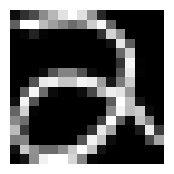

Predicted: 3, Actual: 5. Wrong 6 times


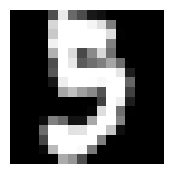

Predicted: 8, Actual: 7. Wrong 6 times


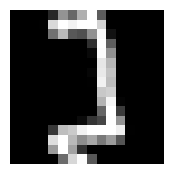

Predicted: 5, Actual: 3. Wrong 6 times


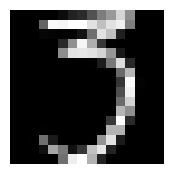

Predicted: 7, Actual: 8. Wrong 6 times


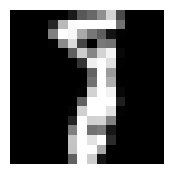

In [23]:
def visualize_params(params):
    plt.figure(figsize=(2, 2))
    plt.imshow(np.reshape(params, (16,16)), cmap='gray')
    plt.axis('off')
    plt.show()

def calc_mistaken_predictions(confusion_stats):
    mistakes_by_count = {}

    for confusion_stat in confusion_stats:
        test_X, test_Y, preds = confusion_stat
        mistaken_indices = np.where(test_Y != preds)[0]

        for idx in mistaken_indices:
            key = (tuple(test_X[idx]), test_Y[idx], preds[idx])
            mistakes_by_count[key] = mistakes_by_count.get(key, 0) + 1

    return mistakes_by_count

mistakes = calc_mistaken_predictions(q3_confusion_stats)
worst_5 = sorted(mistakes.items(), key=lambda x: x[1], reverse=True)[:5]

for dict_item in worst_5:
    info_tuple = dict_item[0]
    print(f"Predicted: {info_tuple[2]}, Actual: {int(info_tuple[1])}. Wrong {dict_item[1]} times")
    visualize_params(info_tuple[0])

#### Gaussian Kernels!

In [12]:
def get_gaussian_kernel(c):
    """
    Returns a Gaussian kernel with specified width

    Args:
        c: inverse width of gaussian kernel
    Returns:
        gaussian kernel function
    """
    @jit(nopython=True)
    def gaussian_kernel(p, q):
        return np.exp(-c * np.sum((p - q) ** 2))
    
    return gaussian_kernel

gaussian_params = np.linspace(0.004, 0.020, 5)
gaussian_perceptrons = [MultiClassKernelPerceptron(get_gaussian_kernel(c)) for c in gaussian_params]
gaussian_kernels = [p.get_kernel_matrix(p.kernel, data) for p in gaussian_perceptrons]

In [13]:
q5_stats = run_20_iters(gaussian_perceptrons, gaussian_kernels, data)
q5_summary = [get_confidence_range(runs) for runs in q5_stats]

print()
print("Test accuracy by gaussian kernel param")
for stat in q5_summary:
    print(gaussian_params[i], "-", prettify_stat(stat))

Currently running iter 0
Currently running iter 1
Currently running iter 2
Currently running iter 3
Currently running iter 4
Currently running iter 5
Currently running iter 6
Currently running iter 7
Currently running iter 8
Currently running iter 9
Currently running iter 10
Currently running iter 11
Currently running iter 12
Currently running iter 13
Currently running iter 14
Currently running iter 15
Currently running iter 16
Currently running iter 17
Currently running iter 18
Currently running iter 19

Test accuracy by kernel degree
0.9836, 0.9891
0.9861, 0.9911
0.9860, 0.9908
0.9871, 0.9906
0.9859, 0.9912


In [47]:
q5_cv_stats, q5_cv_cs = run_cv_20_iters(gaussian_perceptrons, gaussian_kernels, data, gaussian_params)

# Summary statistics!
q5_cv_summary_accuracies = get_confidence_range(q5_cv_stats)
q5_cv_summary_cs = get_confidence_range(q5_cv_cs)

print()
print("Cross-validated accuracy")
print(prettify_stat(q5_cv_summary_accuracies))
print("Cross-validated c's")
print(prettify_stat(q5_cv_summary_cs))

Currently running iter 0
Currently running iter 1


KeyboardInterrupt: 

#### Quesiton 6: All v All Multiclass Perceptron

In [44]:
class AllVAllPerceptron(MultiClassKernelPerceptron):
    """
    An All v All multiclass implementation of the kernel perceptron
    Designed for the MNIST dataset to classify digits 0-9
    """
        
    def __init__(self, kernel, num_digits=10):
        """
        Instantiates the perceptron instance

        Args:
            kernel: kernel function to use
            num_digits: optional param- number of digits to classify,
                assumes digits range from 0...num_digits
        """
        super().__init__(kernel, num_digits)

    def train(self, X, Y, kernel_matrix=None, epochs=10):   
        """
        Trains the perceptron

        Args:
            X: training data (n x d)
            Y: training labels (n x 1)
            kernel_matrix: optional pre-calculated kernel matrix
            epochs: number of epochs to run
        """
        self.X_training = X
        Y = Y.astype(int)

        # Calculate gram matrix if necessary
        if kernel_matrix is None:
            kernel_matrix = self.get_kernel_matrix(self.kernel, X)

        # Find the indices of Y (and X) that correspond to each digit
        self.indices_of_digits = []
        for i in range(self.num_classes):
            digit_indices = np.where(Y == i)[0]
            self.indices_of_digits.append(digit_indices)
            
        self.counts_by_digit = [len(indices) for indices in self.indices_of_digits]

        # There are only (10x9)/2=45 unique pairs, but let's use symmetry and referencing
        #   to make life a little easier for us. (x,y) and (y,x) will point to the same array
        self.alphas = np.empty((self.num_classes, self.num_classes), dtype=object)
        for i in range(self.num_classes):
            for j in range(i+1, self.num_classes):
                total_data = self.counts_by_digit[i] + self.counts_by_digit[j]
                
                # Store the current index as the last element of the array
                current_alpha = np.zeros(total_data+1, dtype=np.float32)
                self.alphas[i, j] = current_alpha
                self.alphas[j, i] = current_alpha

        # Get the sub-kernel indices that correspond to each classifier
        self.kernel_indices = np.empty((self.num_classes, self.num_classes), dtype=object)
        for i in range(self.num_classes):
            for j in range(i+1, self.num_classes):
                current_indices = np.sort(np.append(self.indices_of_digits[i], self.indices_of_digits[j]))
                self.kernel_indices[i, j] = current_indices
                self.kernel_indices[j, i] = current_indices

        num_data = kernel_matrix.shape[0]
        for epoch in range(epochs):
            for i in range(num_data):
                label = Y[i]
                subkernel = kernel_matrix[i]
                for digit, alpha in enumerate(self.alphas[label,:]):
                    if (digit == label): continue
                    
                    # We only want the kernel corresponding to the current two digits!
                    data_kernel = subkernel[self.kernel_indices[digit,label]]
                    decision = np.sign(np.dot(alpha[:-1], data_kernel))

                    # Assume that positive values = smaller label, negative values = bigger label
                    correct_sign = -1 if digit < label else 1
                    if (decision != correct_sign):
                        # We are storing the current index in alpha[-1]
                        alpha[int(alpha[-1])] += correct_sign
                    
                    # We are using alpha[-1] to store the index of the data. Increment it here
                    alpha[-1] = (alpha[-1] + 1) % (len(alpha)-1)
                
    def predict(self, X, kernel_matrix=None):
        """
        Predicts the labels of a new set of data

        Args:
            X: data to classify
            kernel_matrix: an optional parameter for a precalculated kernel
                between X and the training data
        """
        y_hats = []
        if kernel_matrix is None:
            kernel_matrix = self.get_kernel_matrix(self.kernel, X, self.X_training)
        
        for data_index, data in enumerate(X):
            predictions = np.zeros(self.num_classes)
            for i in range(self.num_classes):
                for j in range(i+1, self.num_classes):
                    # Get the sub-kernel that corresponds to the (i, j) digits
                    cur_indices = self.kernel_indices[i,j]
                    cur_kernel = kernel_matrix[data_index,cur_indices]
                    # The last alpha entry is our count! Discard for prediction
                    cur_alpha = self.alphas[i,j][:-1]

                    # Our classifiers are set up to always predict the smaller class
                    #   Thus, a positive value indicates class i
                    cur_pred = i if np.dot(cur_kernel, cur_alpha) >= 0 else j
                    predictions[cur_pred] += 1
            prediction = np.argmax(predictions)
            y_hats.append(prediction)

        return y_hats

In [45]:
allvall_perceptrons = [AllVAllPerceptron(get_polynomial_kernel(p)) for p in poly_params]
q6_stats = run_20_iters(allvall_perceptrons, poly_kernels, data)

print()
print("Test accuracy by kernel degree (1=7)")
for i, stat in enumerate(q6_stats):
    print(poly_params[i], "-", prettify_stat(get_confidence_range(stat)))

Currently running iter 0
Currently running iter 1
Currently running iter 2
Currently running iter 3
Currently running iter 4

Test accuracy by kernel degree (1=7)
1 - 0.9805, 0.9862
2 - 0.9861, 0.9909
3 - 0.9859, 0.9911
4 - 0.9860, 0.9916
5 - 0.9835, 0.9885
6 - 0.9829, 0.9866
7 - 0.9832, 0.9863


In [43]:
q6_stats_b, q6_ds = run_cv_20_iters(allvall_perceptrons, poly_kernels, data, poly_params)

q6_summary_accuracies = get_confidence_range(q6_stats_b)
q6_summary_degrees = get_confidence_range(q6_ds)

print("Cross-validated accuracy")
print(prettify_stat(q6_summary_accuracies))
print("Cross-validated degrees")
print(prettify_stat(q6_summary_degrees))


Currently running iter 0
Currently running iter 1


KeyboardInterrupt: 